In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import math
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from glob import glob
import os.path
from collections import OrderedDict

%matplotlib inline

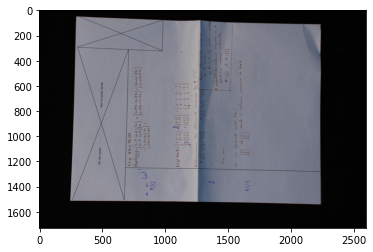

In [2]:
img0 = cv2.imread('./_data/scanprepa/Math Spe/Math/IMG_2676.JPG')
rotation = -90


plt.imshow(img0)

# Image rotation

CPU times: user 719 ms, sys: 3.23 ms, total: 722 ms
Wall time: 98.2 ms


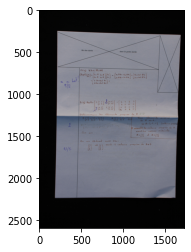

In [3]:
def rotateAboutCenter(src, angle, scale=1.):
    """Rotate an image by a given angle."""
    w = src.shape[1]
    h = src.shape[0]
    rangle = np.deg2rad(angle)  # angle in radians
    # now calculate new image width and height
    nw = (abs(np.sin(rangle)*h) + abs(np.cos(rangle)*w))*scale
    nh = (abs(np.cos(rangle)*h) + abs(np.sin(rangle)*w))*scale
    # ask OpenCV for the rotation matrix
    rot_mat = cv2.getRotationMatrix2D((nw*0.5, nh*0.5), angle, scale)
    # calculate the move from the old center to the new center combined
    # with the rotation
    rot_move = np.dot(rot_mat, np.array([(nw-w)*0.5, (nh-h)*0.5,0]))
    # the move only affects the translation, so update the translation
    # part of the transform
    rot_mat[0,2] += rot_move[0]
    rot_mat[1,2] += rot_move[1]
    return cv2.warpAffine(src, rot_mat,
                          (int(math.ceil(nw)), int(math.ceil(nh))),
                         flags=cv2.INTER_LANCZOS4)

%time img1 = rotateAboutCenter(img0, rotation)

plt.imshow(img1)

# Contour detection.

## Extract contours

In [4]:
# Some useful functions

def printContoursDetails(contours):
    """Prints the details of a contour."""
    print("{} contours:".format(len(contours)))
    for i, c in enumerate(contours):
        print(" -{} ({} points): {}".format(i, len(c), str(c).replace('\n', '')))
        
def points2Contour(points):
    """Returns a 'contour' based on a list of 2-uplets."""
    return np.array([[[p[0], p[1]]] for p in points], dtype='int32')

def contour2Points(contour):
    """Returns a list of 2-uplets based on a contour."""
    return [(point[0][0], point[0][1]) for point in contour]

def contour2Segments(contour):
    """Returns a list of segments, defined by two points based on a contour."""
    points = contour2Points(contour)
    nextpoints = points[1:] + points[:1]
    return list(zip(points, nextpoints))

def segments2Contour(segments):
    """Returns a 'contour' based on a list of segments."""
    points = [s[0] for s in segments]
    return points2Contour(points)
    
def intersection_lines(a1,a2,b1,b2):
    """Returns the intersection of two lines, each defined by 2 points."""
    x1, y1 = a1
    x2, y2 = a2
    x3, y3 = b1
    x4, y4 = b2
    den = 1.0*(y4-y3)*(x2-x1)-(x4-x3)*(y2-y1)
    if den == 0:
        return None
    num = 1.0*(x4-x3)*(y1-y3)-(y4-y3)*(x1-x3)
    ua = num / den
    return int(x1+ua*(x2-x1)), int(y1+ua*(y2-y1))

def angle(seg1, seg2):
    """Return the angle defined by two segments."""
    x1 = seg1[1][0]-seg1[0][0]
    y1 = seg1[1][1]-seg1[0][1]
    x2 = seg2[1][0]-seg2[0][0]
    y2 = seg2[1][1]-seg2[0][1]
    normdot = (1.0*x1*x2+y1*y2) / (math.sqrt(x1**2+y1**2)*math.sqrt(x2**2+y2**2))
    return math.degrees(math.acos(normdot))

4 contours:
 -0 (379 points): [[[ 481  687]] [[ 480  688]] [[ 480  734]] [[ 479  735]] [[ 479  769]] [[ 484  769]] [[ 485  770]] [[ 485  774]] [[ 495  774]] [[ 495  771]] [[ 496  770]] [[ 496  762]] [[ 497  761]] [[ 497  759]] [[ 498  758]] [[ 499  758]] [[ 500  757]] [[ 501  758]] [[ 501  761]] [[ 506  761]] [[ 507  762]] [[ 507  763]] [[ 508  764]] [[ 508  767]] [[ 518  767]] [[ 519  766]] [[ 520  766]] [[ 521  765]] [[ 522  765]] [[ 523  766]] [[ 526  766]] [[ 527  767]] [[ 538  767]] [[ 538  761]] [[ 539  760]] [[ 540  761]] [[ 540  763]] [[ 545  763]] [[ 546  764]] [[ 546  765]] [[ 545  766]] [[ 541  766]] [[ 541  767]] [[ 540  768]] [[ 540  773]] [[ 539  774]] [[ 538  773]] [[ 528  773]] [[ 528  775]] [[ 527  776]] [[ 527  777]] [[ 526  778]] [[ 519  778]] [[ 517  776]] [[ 517  774]] [[ 507  774]] [[ 507  776]] [[ 506  777]] [[ 505  776]] [[ 487  776]] [[ 487  778]] [[ 486  779]] [[ 479  779]] [[ 479  805]] [[ 478  806]] [[ 478  875]] [[ 477  876]] [[ 477  937]] [[ 476  938]] [[ 

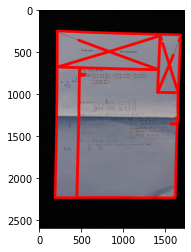

In [5]:
# Find all the contours in the page

def findContours(image):
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.erode(img, np.ones((3, 3), np.uint8), iterations=5)
    img = cv2.dilate(img, np.ones((3, 3), np.uint8), iterations=5)
    ret, img = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY)    
    contours, hierarchy = cv2.findContours(img,
                                           cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_SIMPLE)
    return contours


contours = findContours(img1)

# Display
printContoursDetails(contours)
img11 = img1.copy()
cv2.drawContours(img11, contours, -1, (255,0,0), 30)
plt.imshow(img11)


## Filter contours

In [6]:
# Filter out contours with small area

# This is the minimum area (fraction of the picure) for a contour
# to be consider worth to be part of the page)
minarea = 0.01

def filterOutSmallContours(contours, minarea, img):
    x, y, _ = img.shape
    minarea = (x * y) * minarea
    return [c for c in contours if cv2.contourArea(c) > minarea]

contours = filterOutSmallContours(contours, minarea, img1)

printContoursDetails(contours)

4 contours:
 -0 (379 points): [[[ 481  687]] [[ 480  688]] [[ 480  734]] [[ 479  735]] [[ 479  769]] [[ 484  769]] [[ 485  770]] [[ 485  774]] [[ 495  774]] [[ 495  771]] [[ 496  770]] [[ 496  762]] [[ 497  761]] [[ 497  759]] [[ 498  758]] [[ 499  758]] [[ 500  757]] [[ 501  758]] [[ 501  761]] [[ 506  761]] [[ 507  762]] [[ 507  763]] [[ 508  764]] [[ 508  767]] [[ 518  767]] [[ 519  766]] [[ 520  766]] [[ 521  765]] [[ 522  765]] [[ 523  766]] [[ 526  766]] [[ 527  767]] [[ 538  767]] [[ 538  761]] [[ 539  760]] [[ 540  761]] [[ 540  763]] [[ 545  763]] [[ 546  764]] [[ 546  765]] [[ 545  766]] [[ 541  766]] [[ 541  767]] [[ 540  768]] [[ 540  773]] [[ 539  774]] [[ 538  773]] [[ 528  773]] [[ 528  775]] [[ 527  776]] [[ 527  777]] [[ 526  778]] [[ 519  778]] [[ 517  776]] [[ 517  774]] [[ 507  774]] [[ 507  776]] [[ 506  777]] [[ 505  776]] [[ 487  776]] [[ 487  778]] [[ 486  779]] [[ 479  779]] [[ 479  805]] [[ 478  806]] [[ 478  875]] [[ 477  876]] [[ 477  937]] [[ 476  938]] [[ 

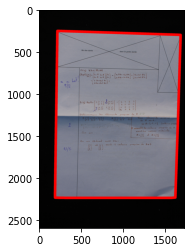

In [7]:
def buildContour(contours):
    contour = np.concatenate(contours)
    return cv2.convexHull(contour)

contour = buildContour(contours)

# Display
img111 = img1.copy()
cv2.drawContours(img111, [contour], -1, (255,0,0), 30)
plt.imshow(img111)

## Rework the contour to find the 4 angles of the sheet

1 contours:
 -0 (5 points): [[[1676  296]] [[1614 2229]] [[1567 2233]] [[ 191 2231]] [[ 217  249]]]


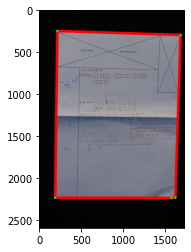

In [12]:
# Approximate the contours

# The value of alpha should be "right" to have a contour with
# at least 4 segments "representative" of the edges of the
# sheet of paper.
# "Representative" could be at least a 1/4 of the image smallest
# dimension.
# Good value of alpha: 0.0005
alpha = 0.0005

def approximateContour(contour, alpha):
    return cv2.approxPolyDP(contour, alpha*cv2.arcLength(contour, True), True)

contour = approximateContour(contour, alpha)

# Display
printContoursDetails([contour])    
img13 = img1.copy()
cv2.drawContours(img13, [contour], -1, (255,0,0), 30)
cv2.drawContours(img13, contour, -1, (0,255,0), 30)
plt.imshow(img13)


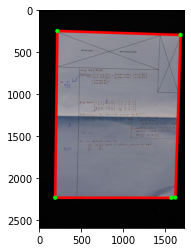

In [13]:
# Remove segments that form broken angles

# Angle above which an angle is not considered a straigh line
# or a 90 degrees angle (90-theta in this last case).
theta = 10

# Ratio of the length of a page below which a segment cannot
# be a broken angle
gamma = .2

def removeBrokenAngles(contour, theta, gamma, img):

    maxBrokenAngleLength = gamma * min(img.shape[:2])
    
    # Retrieve all segments that participate to angles different than 0 or 90 degrees.
    segments = contour2Segments(contour)
    toremove = []
    previous_current_next = list(zip(range(len(segments)),
                                     segments[-1:]+segments[:-1],
                                     segments,
                                     segments[1:]+segments[:1]))    
    for i, prevseg, seg, nextseg in previous_current_next:
        prevangle = abs(angle(prevseg, seg))
        nextangle = abs(angle(seg, nextseg))
        length = math.sqrt((seg[1][0]-seg[0][0])**2+(seg[1][1]-seg[0][1])**2)
        if ((theta < prevangle < 90-theta) and
            (theta < nextangle < 90-theta) and
            (length < maxBrokenAngleLength)):
            toremove.append(i)
    
    # Remove/update segments
    i = 0
    removed = 0
    length = len(segments)
    while i < length:
        iminus, iplus = (i-1)%length, (i+1)%length 
        if i+removed in toremove:
            # Compute intersection of previous & next segments
            (a1, a2) = segments[iminus]
            (b1, b2) = segments[iplus]
            (x, y) = intersection_lines(a1,a2,b1,b2)
            # Update previous & next segments
            segments[iminus] = (segments[iminus][0], (x, y))
            segments[iplus] = ((x, y), segments[iplus][1])
            # Remove current segment
            segments = segments[:i]+segments[i+1:]
            removed += 1
            length -= 1
        else:
            i += 1
        
    return segments2Contour(segments)
 
contour = removeBrokenAngles(contour, theta, gamma, img1)

# Display
img15 = img1.copy()
cv2.drawContours(img15, [contour], -1, (255,0,0), 30)
cv2.drawContours(img15, contour, -1, (0,255,0), 50)
plt.imshow(img15)


1 contours:
 -0 (4 points): [[[ 217  249]] [[ 191 2231]] [[1614 2229]] [[1676  296]]]


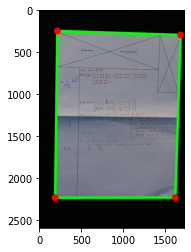

In [14]:
def findCorners(contour):
    v1 = [i[0][0]+i[0][1] for i in contour]
    topleft = v1.index(min(v1))
    bottomright = v1.index(max(v1))
    v2 = [i[0][0]-i[0][1] for i in contour]
    bottomleft = v2.index(min(v2))
    topright = v2.index(max(v2))
    ordered_indexes = [topleft, bottomleft, bottomright, topright]
    ordered_contour = np.array([contour[i] for i in ordered_indexes])
    return ordered_contour

contour = findCorners(contour)

#Display
printContoursDetails([contour])
imgt = img1.copy()
cv2.drawContours(imgt, [contour], -1, (0,255,0), 30)
cv2.drawContours(imgt, contour, -1, (255,0,0), 80)
plt.imshow(imgt)

# Determine 'A4' zone

In [15]:
def computeA4subarea(img):
    """Return the dimension (rows, cols) of the biggest subarea
    of the image that would have the same proportion than an
    A4 page."""
    rows, cols, ch = img.shape
    rowsA4, colsA4 = 297, 210
    newrows, newcols = rows, cols
    if 1.0*rows/cols > rowsA4/colsA4:
        newrows = int(1.0 * cols * rowsA4 / colsA4)
    else:
        newcols = int(1.0 * rows * colsA4 / rowsA4)
    return newrows, newcols

newrows, newcols = computeA4subarea(img1)

# Display
rows, cols, ch = img1.shape
print("image dimension:    ", rows, cols)
print("proposed dimension: ", newrows, newcols)


image dimension:     2592 1729
proposed dimension:  2445 1729


# Changement of perspective

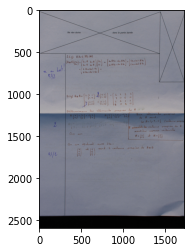

In [16]:

def reframePage(contour, img, rows, cols):
    # The points that will define the transformation
    pts_origin = np.float32(contour)
    pts_destination = np.float32([[0,0],
                                  [0,rows],
                                  [cols,rows],
                                  [cols,0]])
    # Apply the transformation
    imgrows, imgcols, _ = img1.shape
    M = cv2.getPerspectiveTransform(pts_origin, pts_destination)
    newimg = cv2.warpPerspective(img, M, (imgcols,imgrows))
    return newimg
    
img2 = reframePage(contour, img1, newrows, newcols)    
    
#cv2.imwrite("out2.jpg", img2)
plt.imshow(img2)

# Crop the image

(2445, 1729, 3)


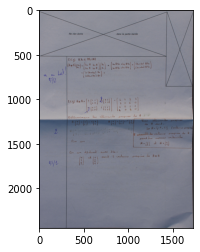

In [17]:

def cropImage(img, rows, cols):
    return img[0:rows, 0:cols]
    
img3 = cropImage(img2, newrows, newcols)

# Display
print(img3.shape)
plt.imshow(img3)

# Batch processing

In [24]:
def detectPage(img, alpha=0.0005, theta=10, gamma=0.2, minarea=0.01):
    contours = findContours(img)
    contours = filterOutSmallContours(contours, minarea, img)
    contour = buildContour(contours)
    #contours = convexHulls(contours)
    #contours = filterBasedOnLength(contours)
    #contour = selectContourBasedOnArea(contours)
    contour = approximateContour(contour, alpha)
    contour = removeBrokenAngles(contour, theta, gamma, img)
    contour = findCorners(contour)
    return contour

def reframeImage(img, contour):
    rows, cols = computeA4subarea(img)
    img = reframePage(contour, img, rows, cols)
    img = cropImage(img, rows, cols)
    return img

In [41]:
rm ./_out/*

In [42]:
#imgpaths = glob('./_data/scanprepa/Math Spe/Math/Devoirs & Exercices/*')
imgpaths = glob('./_data/scanprepa/Math Sup/Math/Devoirs/*')

imgpaths.sort()
imgpaths = [imgpath for imgpath in imgpaths if imgpath[-4:].lower() == ".jpg"]

rotation = -90

imagesDict = OrderedDict()
    
for imgpath in imgpaths:

    basename = os.path.basename(imgpath)
    print(basename)

    img = cv2.imread(imgpath)
    img = rotateAboutCenter(img, rotation)
    contour = detectPage(img)
    newimg = reframeImage(img, contour)

    imagesDict[basename] = {"contour": str(contour2Points(contour)),
                            "rotation": rotation}
             
    outfile = os.path.join('./_out/', basename)
    cv2.imwrite(outfile, newimg)

    

IMG_3474.JPG
IMG_3475.JPG
IMG_3476.JPG
IMG_3477.JPG
IMG_3478.JPG
IMG_3479.JPG
IMG_3480.JPG
IMG_3481.JPG
IMG_3482.JPG
IMG_3483.JPG
IMG_3484.JPG
IMG_3485.JPG
IMG_3486.JPG
IMG_3487.JPG
IMG_3488.JPG
IMG_3489.JPG
IMG_3490.JPG
IMG_3491.JPG
IMG_3492.JPG
IMG_3493.JPG
IMG_3494.JPG
IMG_3495.JPG
IMG_3496.JPG
IMG_3497.JPG
IMG_3498.JPG
IMG_3499.JPG
IMG_3500.JPG
IMG_3501.JPG
IMG_3502.JPG
IMG_3503.JPG
IMG_3504.JPG
IMG_3505.JPG
IMG_3506.JPG
IMG_3507.JPG
IMG_3508.JPG
IMG_3509.JPG
IMG_3510.JPG
IMG_3511.JPG
IMG_3512.JPG
IMG_3513.JPG
IMG_3514.JPG
IMG_3515.JPG
IMG_3516.JPG
IMG_3517.JPG
IMG_3518.JPG
IMG_3519.JPG
IMG_3520.JPG
IMG_3521.JPG
IMG_3522.JPG
IMG_3523.JPG
IMG_3524.JPG
IMG_3525.JPG
IMG_3526.JPG
IMG_3527.JPG
IMG_3528.JPG
IMG_3529.JPG
IMG_3530.JPG
IMG_3531.JPG
IMG_3532.JPG
IMG_3533.JPG
IMG_3534.JPG
IMG_3535.JPG
IMG_3536.JPG
IMG_3537.JPG
IMG_3538.JPG
IMG_3539.JPG
IMG_3540.JPG
IMG_3541.JPG
IMG_3542.JPG
IMG_3543.JPG
IMG_3544.JPG
IMG_3545.JPG
IMG_3546.JPG
IMG_3547.JPG
IMG_3548.JPG
IMG_3549.JPG
IMG_3550.JPG

In [43]:
# Save data

with open('./_out/data.txt', 'w') as out:
    print(str(imagesDict), file=out) 
    

In [44]:
# Read data

with open("./_out/data.txt", "r") as data:
    t = data.read()
    x = eval(t)

# Create PDF file

In [45]:
import img2pdf

path = './_out/'
images = os.listdir(path)
images = [os.path.join(path, i) for i in images if i[-4:].lower() == ".jpg"]
images.sort()

with open("_out.pdf", "wb") as f:
    f.write(img2pdf.convert(images))